<H1>Relationship between IL and price change in a stableswap pool</H1>
Here we investigate the impermanent loss experienced by an LP in a stableswap pool when one of the assets depegs (its value deviates from 1USD). Because the assets in a stableswap pool are expected to remain stable, the pool is optimized to give a better execution price, with less slippage, at the expense of being more vulnerable to impermanent loss in the event of a price change. For the sake of simplicity, the LP both deposits and withdraws a proportional amount of each token (so that these trades don't induce further price changes). Note that the general dynamics and scale of the impermanent loss will hold regardless of which asset the LP chooses to deposit or withdraw.
<br><br>
An important parameter of the stableswap pool is its amplification, which affect the shape of the price curve. At an amplification of 0, the stableswap pool behaves identically to an XYK pool, whereas at an amplification of infinity, the price of each asset remains at exactly 1 until the pool runs out of liquidity. At an intermediate value, the price remains stable at a wider range of balances than it would in an XYK pool, but hits a 'cliff' when the balance shifts too far in either direction. Higher values give a more stable price but a steeper cliff, and are more appropriate when there is high confidence in the stability of the underlying assets. Here we will graph the IL dynamics for a range of amplification values.

In [250]:
import sys
import os
import glob
import random
import copy
import math
from IPython.display import display, Markdown
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, value_assets, usd_price, lrna_price
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)
# price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 120)

assets = {
    'USDA': {'usd price': 1, 'weight': 0.25},
    'USDB': {'usd price': 1, 'weight': 0.25},
    'USDC': {'usd price': 1, 'weight': 0.25},
    'USDD': {'usd price': 1, 'weight': 0.25}
}

assert sum([t['weight'] for t in assets.values()]) == 1

initial_tvl = 1000000
initial_state = GlobalState(
    pools={
        'stableswap': StableSwapPoolState(
            tokens={
                tkn: initial_tvl * assets[tkn]['weight'] for tkn in assets
            },
            amplification=10,
            trade_fee=0
        )
    },
    agents = {
        'LP': Agent(
            holdings={tkn: 1 for tkn in assets},
            trade_strategy=invest_all('stableswap')
        ),
        'Trader': Agent(
            holdings={tkn: 10000000000000 for tkn in assets}
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets}
)


In [251]:
invested_state = initial_state.agents['LP'].trade_strategy.execute(
    initial_state.copy(),
    agent_id='LP'
)
amps = [25, 50, 100, 200, 400, 800]
trade_range = [[200000, -100000]] * len(amps)
# print(trade_range)
for i, amp in enumerate(amps):
    for j, target_price in enumerate([0.001, 200]):
        invested_state.pools['stableswap'].amplification = amp
        try_state = invested_state.copy()
        spot_price = [1, 2000][j]
        while (
            spot_price > target_price 
            and not try_state.pools['stableswap'].fail
        ):
            # find the correct trade size to get the price we want
            if j == 0:
                trade_range[i][j] *= 1.0001
            elif j == 1:
                trade_range[i][j] /= 1.0001
            try_state = invested_state.copy()
            try_state.pools['stableswap'].swap_one(
                agent=try_state.agents['Trader'],
                tkn_sell='USDA',
                quantity=trade_range[i][j]
            )
            spot_price = try_state.pools['stableswap'].spot_price('USDA', numeraire='USDD')
        print(spot_price, trade_range[i][j])
        if try_state.pools['stableswap'].fail:
            print('trade failed, use a smaller initial value or a smaller growth factor')

        if i < len(amps) - 1:
            trade_range[i+1] = copy.copy(trade_range[i])
print(trade_range)

0.000995444390312422 247276.40443434505
156.87953617143862 -99990.00099990002
0.000977326252482079 247647.57879376572
199.71967208980743 -96686.31486433979
0.0009877770884735417 247944.91939021496
199.94530000067437 -92802.53170641157
0.000980612059546324 248217.79521216897
199.67437907817265 -90032.92489873343
0.000995282647861672 248441.28060711964
199.67207475942692 -88073.92649009275
0.0009588261640137211 248664.96721939923
199.42914906713446 -86684.69418227047
[[247276.40443434505, -99990.00099990002], [247647.57879376572, -96686.31486433979], [247944.91939021496, -92802.53170641157], [248217.79521216897, -90032.92489873343], [248441.28060711964, -88073.92649009275], [248664.96721939923, -86684.69418227047]]


In [252]:
test_state = invested_state.copy()
test_state.amplification=amps[0]
print(trade_range)
test_state.pools['stableswap'].swap_one(
    agent=try_state.agents['Trader'],
    tkn_sell='USDA',
    quantity=trade_range[0][1]
)
print(test_state.pools['stableswap'].spot_price('USDA', 'USDD'))

[[247276.40443434505, -99990.00099990002], [247647.57879376572, -96686.31486433979], [247944.91939021496, -92802.53170641157], [248217.79521216897, -90032.92489873343], [248441.28060711964, -88073.92649009275], [248664.96721939923, -86684.69418227047]]
4914.45636725769


In [262]:
steps = 2000
amp_events = []
trade_sizes = []
for i, amp in enumerate(amps):
    invested_state.pools['stableswap'].amplification = amp
    events = []
    trade_size_min, trade_size_max = trade_range[i][1], trade_range[i][0]
    # trade_sizes.append([trade_size_min + j * (trade_size_max - trade_size_min) / steps for j in range(steps)][::-1])
    # use a sigmoid function for a better price distribution VV
    trade_sizes.append(
        [(1 / (1 + math.exp(j / (steps - 1) * 12 - 6)) * 2 - 1) * (trade_size_max if j < steps / 2 else -trade_size_min) for j in range(steps)]
    )
    print(trade_sizes[-1][0], trade_sizes[-1][-1])
    # trade to change the price of assets. 
    # We assume that whatever the resulting price is the new market price, and the trade is an arb trade.
    
    for trade_size in trade_sizes[-1]:
        new_state = invested_state.copy()
        new_state.pools['stableswap'].swap_one(
            agent=new_state.agents['Trader'],
            tkn_sell='USDA',
            quantity=trade_size
        )
        if new_state.pools['stableswap'].fail:
            print(f"failed with trade size {trade_size}")
        new_state.external_market['USDA'] = new_state.pools['stableswap'].spot_price('USDA', numeraire='USDD')
        events.append(new_state)
        
    for event in events:
        # agent withdraws assets in equal proportion
        event.pools['stableswap'].remove_uniform(
            agent=event.agents['LP'],
            shares_removed=event.agents['LP'].holdings['stableswap']
        )

    amp_events.append(copy.deepcopy(events))
    
print('simulation finished.')

246053.5617069576 -99495.52581609144
246422.9005177458 -96208.1772222133
246718.77069170662 -92343.60032862835
246990.29707550816 -89587.6899088051
247212.6772801334 -87638.37922982244
247435.25770701826 -86256.0170179487
simulation finished.


0.0053090963534165


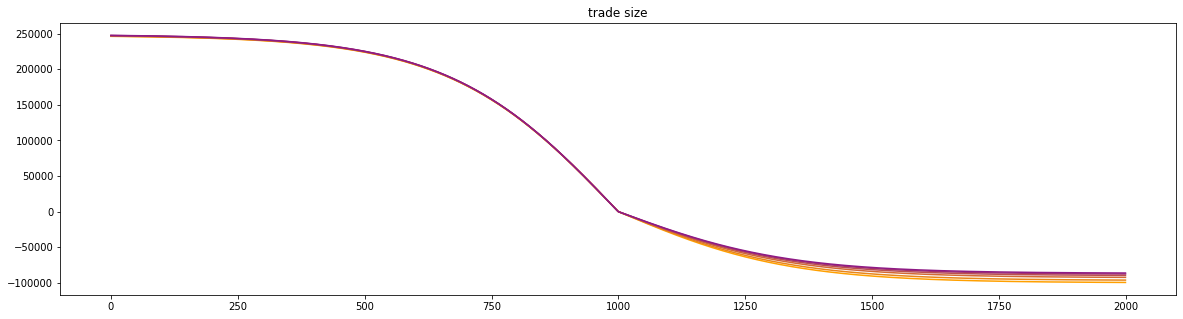

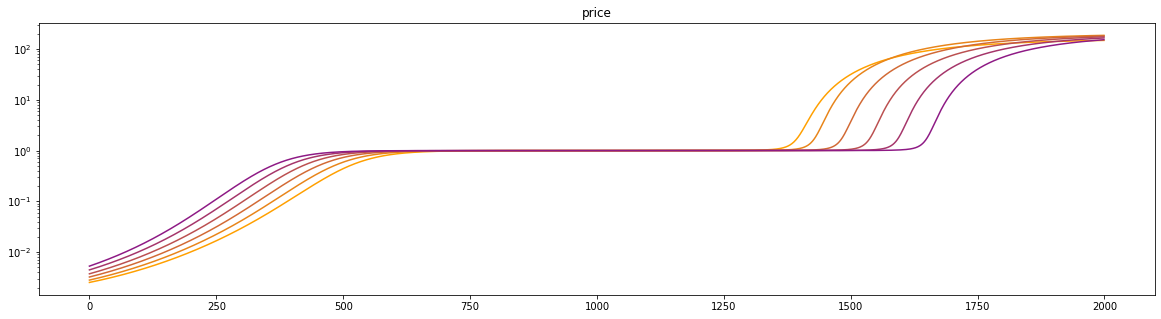

In [263]:
# colors = pu.color_gradient(len(amp_events), (255, 160, 0), (120, 0, 160))
# plt.figure(figsize=(20,5))
# for i in range(len(amps)):
#     plt.plot(trade_sizes[i], color=colors[i])
#     plt.title('trade size')

# plt.figure(figsize=(20, 5))
# for i in range(len(amps)):
#     usda_prices = pu.get_datastream(amp_events[i], asset='USDA')
#     plt.plot(usda_prices, color=colors[i])
#     plt.yscale('log')
#     plt.title('price')

# print(min(usda_prices))


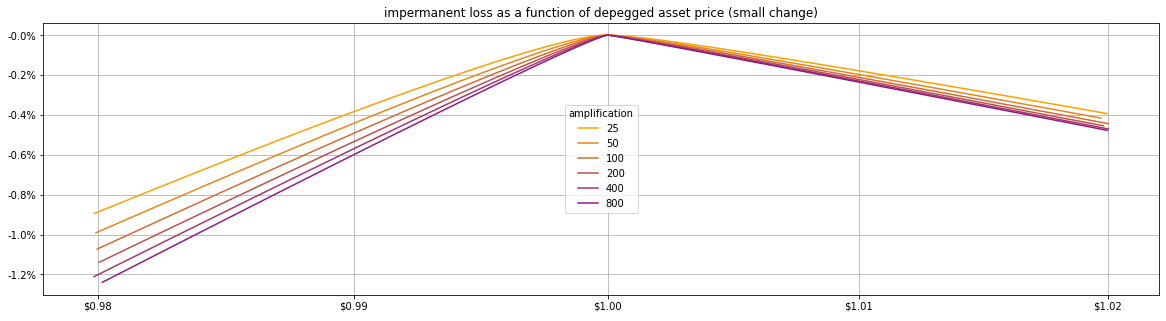

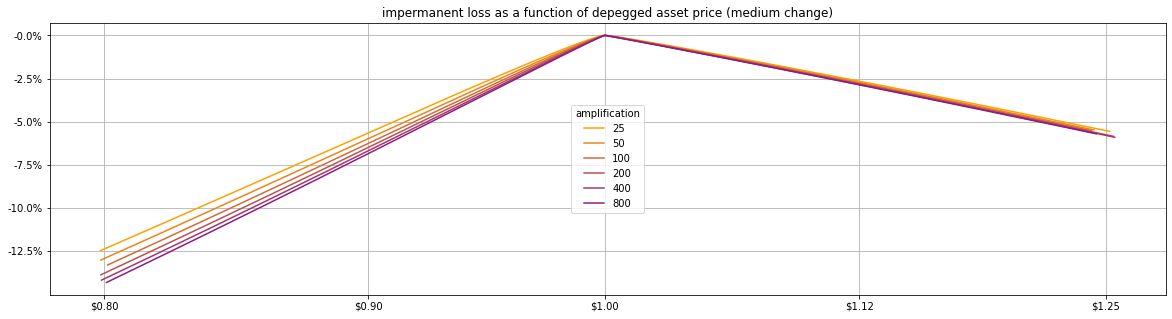

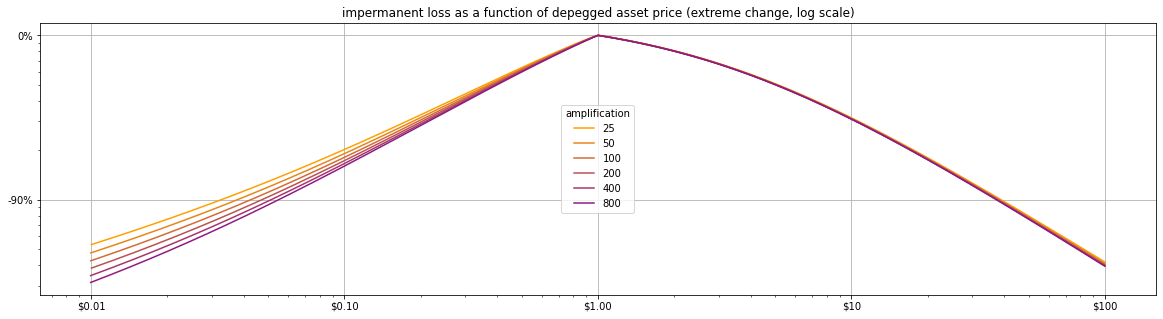

In [264]:
colors = pu.color_gradient(len(amp_events), (255, 160, 0), (120, 0, 160))
impermanent_loss = []
usda_prices = []
for i, events in enumerate(amp_events):
    prices = [{tkn: event.external_market[tkn] for tkn in assets} for event in events]
    withdraw_vals = [
        value_assets(prices=prices[i], assets=event.agents['LP'].holdings)
        for i, event in enumerate(events)
    ]

    deposit_vals = [
        value_assets(prices=prices[i], assets=initial_state.agents['LP'].holdings)
        for i, event in enumerate(events)
    ]
    usda_prices.append([event.external_market['USDA'] for event in amp_events[i]])
    impermanent_loss.append([withdraw_vals[i] / deposit_vals[i] - 1 for i in range(len(amp_events[i]))])

# zoom in
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (small change)')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.98, 0.99, 1, 1.01, 1.02],
    ['$0.98', '$0.99', '$1.00', '$1.01', '$1.02']
)
plt.yticks(
    [-0.002 * i for i in range(7)],
    [f'-{round(0.2 * i * 10, 2) / 10}%' for i in range(7)]
)

# clear default ticks
for t in plt.gca().xaxis.get_minor_ticks():
    t.set_visible(False)

for i, loss in enumerate(impermanent_loss):
    price_min, price_max = 0.98, 1.02
    end_range = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - price_max))[0]) + 1
    start_range = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - price_min))[0])
    plt.plot(usda_prices[i][start_range: end_range], loss[start_range: end_range], color=colors[i])
plt.legend(amps, loc='center', title='amplification')

# medium zoom
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (medium change)')
plt.xscale('log')
plt.grid()
plt.xticks(
    [0.8, 0.9, 1, 1.12, 1.25],
    ['$0.80', '$0.90', '$1.00', '$1.12', '$1.25']
)
plt.yticks(
    [-0.025 * i for i in range(6)],
    [f'-{2.5 * i}%' for i in range(6)]
)

for i, loss in enumerate(impermanent_loss):
    price_min, price_max = 0.8, 1.25
    end_range = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - price_max))[0]) + 1
    start_range = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - price_min))[0])
    plt.plot(usda_prices[i][start_range: end_range], loss[start_range: end_range], color=colors[i])
plt.legend(amps, loc='center', title='amplification')

# zoom out
plt.figure(figsize=(20,5))
plt.title('impermanent loss as a function of depegged asset price (extreme change, log scale)')
plt.xscale('log')
plt.grid()
plt.yscale('log')
plt.yticks(
    [1, 0.1, 0.01, 0.001],
    ['0%', '-90%', '-99%', '-99.9%']
)
tick_prices = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
plt.xticks(
    tick_prices,
    ['$0.001', '$0.01', '$0.10', '$1.00', '$10', '$100', '$1000']
)
if 1 in tick_prices:
    tick_prices.remove(1)


for i, loss in enumerate(impermanent_loss):

    price_min, price_max = 0.01, 100
    end_range = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - price_max))[0]) + 1
    start_range = usda_prices[i].index(sorted(usda_prices[i], key = lambda price: abs(price - price_min))[0])
    plt.plot(usda_prices[i][start_range: end_range], [1 + loss for loss in loss[start_range: end_range]], color=colors[i])

plt.legend(amps, loc='center', title='amplification')

plt.show()